In [5]:
sp500_tickers = [
    "AAPL", "MSFT", "GOOGL", "GOOG", "AMZN", "NVDA", "META", "TSLA", "BRK-B", "UNH",
    "LLY", "JPM", "V", "JNJ", "XOM", "WMT", "MA", "PG", "AVGO", "CVX", "HD", "MRK",
    "ABBV", "COST", "PEP", "ADBE", "KO", "BAC", "CRM", "ORCL", "TMO", "ACN", "INTC",
    "MCD", "ABT", "CSCO", "QCOM", "DHR", "NKE", "WFC", "TXN", "LIN", "AMD", "NEE",
    "AMGN", "PM", "HON", "UNP", "UPS", "MS", "SPGI", "RTX", "INTU", "LOW", "BA",
    "IBM", "AMT", "CAT", "MDT", "PLD", "GS", "ISRG", "CVS", "NOW", "BLK", "GE",
    "DE", "T", "LRCX", "ADI", "CI", "ZTS", "SYK", "C", "TJX", "MU", "SCHW", "ADP",
    "MMC", "BDX", "MO", "PFE", "BKNG", "CHTR", "CB", "REGN", "MDLZ", "VRTX", "USB",
    "PANW", "GILD", "ELV", "LMT", "ADSK", "SO", "PGR", "TGT", "DUK", "AXP",
    "HCA", "AON", "SLB", "CL", "APD", "EOG", "TJX", "AEP", "CSX", "F", "MAR", "GM",
    "ICE", "FDX", "DG", "MNST", "NSC", "EW", "ITW", "MET", "KHC", "TRV", "PSX", "MPC",
    "COF", "SHW", "OXY", "EMR", "SRE", "ROST", "HUM", "AZO", "CDNS", "KMB", "STZ",
    "ORLY", "ADM", "RMD", "PSA", "BIIB", "IDXX", "VLO", "TT", "CMG", "PRU", "WELL",
    "PCAR", "AFL", "SPG", "CTAS", "HAL", "EXC", "DLR", "AIG", "WMB", "ED", "HPQ",
    "YUM", "CTSH", "PAYX", "AMP", "TEL", "EBAY", "WBD", "OKE", "VICI", "PPG", "FITB",
    "EFX", "D", "DFS", "ALL", "MTB", "KEYS", "ANET", "OTIS", "HES", "BKR", "TTWO",
    "APH", "WEC", "ETN", "ECL", "ROK", "MLM", "AVB", "BAX", "NEM", "XYL", "CMS",
    "DOW", "RSG", "MCK", "GWW", "CHD", "CFG", "FAST", "CAH", "NUE", "VRSK", "LEN",
    "ULTA", "CCL", "CNP", "LDOS", "VTR", "CBRE", "IFF", "TSCO", "CAG", "ZBH", "BXP",
    "HOLX", "DPZ", "LUV", "IPG", "AKAM", "MKTX", "MAS", "DRI", "SWKS", "FTNT", "RHI",
    "FANG", "PPL", "AES", "AEE", "STX", "IR", "NTRS", "WY", "HIG", "DHI",
    "CLX", "ARE", "STE", "MTD", "CDW", "CMA", "INVH", "ALGN", "FE", "KIM",
    "ATO", "SNA", "GEN", "LHX", "BALL", "TER", "NDAQ", "BEN", "CRL", "PODD", "KR",
    "HBAN", "ZBRA", "LKQ", "APA", "NTAP", "SJM", "GLW", "TSN", "BWA", "HSIC", "CPB",
    "WRB", "JKHY", "NRG", "JBHT", "TFX", "XRAY", "NWS", "NWSA", "FOX", "FOXA"
]


In [1]:
fewer_sp500_tickers = [
    "AAPL", "MSFT", "UNH", "LLY", "JPM", "JNJ", "XOM", "WMT", "PG", "CVX",
    "HD", "MRK", "COST", "PEP", "ADBE", "KO", "BAC", "ORCL", "INTC",
    "MCD", "ABT", "CSCO", "QCOM", "DHR", "NKE", "WFC", "TXN", "AMD",
    "NEE", "AMGN", "PM", "HON", "UNP", "UPS", "MS", "LOW", "BA", "IBM",
    "CAT", "MDT", "GS", "GE", "DE", "T", "LRCX", "ADI", "CI", "SYK",
    "MU", "SCHW", "ADP", "MMC", "BDX", "PFE", "ADSK", "SO", "PGR", "TGT",
    "AXP", "AON", "SLB", "CL", "APD", "AEP", "CSX", "F", "GM", "FDX",
    "DG", "NSC", "ITW"
]


In [2]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque, namedtuple
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd

snp500_data = None

def fetch_snp500_data(start='1990-1-01', end='2019-04-14'):
    global snp500_data
    # Explicitly set auto_adjust to False to ensure raw prices (suppress warning)
    snp500_data = yf.download('^GSPC', start=start, end=end, auto_adjust=False)
    print("S&P 500 data loaded.")

def get_close_prices():
    global snp500_data
    if snp500_data is not None:
        return snp500_data['Close']

# --------------------------
# Trading Environment
# --------------------------
import gym
import numpy as np
import yfinance as yf

class TradingEnv(gym.Env):
    def __init__(self, stock_prices, dividends, initial_cash=10000,
                 transaction_cost=0.001):
        super().__init__()
        self.initial_cash = initial_cash
        self.transaction_cost = transaction_cost
        self.num_stocks = stock_prices.shape[1]

        # load S&P 500 series once
        snp = yf.download('^GSPC', start='1990-01-01', end='2019-12-31',
                          auto_adjust=False)['Close'].values.astype(np.float32)

        # truncate both series to the same length
        min_len = min(stock_prices.shape[0], snp.shape[0])
        self.stock_prices = stock_prices[:min_len]
        self.snp500 = snp[:min_len]

        # action: weights for [stock₁ … stockₙ, cash], sums to 1
        self.action_space = gym.spaces.Box(
            low=0, high=1, shape=(self.num_stocks + 1,), dtype=np.float32)
        # obs: [prices₁…ₙ, holdings₁…ₙ, cash]
        obs_low  = np.zeros(self.num_stocks*2 + 1, dtype=np.float32)
        obs_high = np.full(self.num_stocks*2 + 1, np.inf, dtype=np.float32)
        self.observation_space = gym.spaces.Box(obs_low, obs_high, dtype=np.float32)

    def reset(self):
        self.current_step = 0
        self.cash = float(self.initial_cash)
        self.holdings = np.zeros(self.num_stocks, dtype=np.float32)
        return self._get_obs()

    def _get_obs(self):
        prices = self.stock_prices[self.current_step]
        return np.concatenate([prices, self.holdings, [self.cash]])

    def step(self, action):
        # if we're at the very end, terminate
        if self.current_step >= len(self.stock_prices) - 1:
            return self._get_obs(), 0.0, True, {}

        # normalize action
        action = np.clip(action, 1e-6, None)
        action = action / action.sum()

        prices      = self.stock_prices[self.current_step]
        stock_vals  = self.holdings * prices
        total_value = stock_vals.sum() + self.cash

        target_stock_vals = action[:-1] * total_value
        target_cash_val   = action[-1]  * total_value

        new_holdings = target_stock_vals / prices
        trades       = np.abs(new_holdings - self.holdings) * prices
        turnover     = trades.sum()

        cost = self.transaction_cost * turnover

        next_prices      = self.stock_prices[self.current_step + 1]
        next_stock_value = (new_holdings * next_prices).sum()
        next_total_value = next_stock_value + target_cash_val - cost

        snp_today = self.snp500[self.current_step]
        snp_next  = self.snp500[self.current_step + 1]
        daily_portf_ret = (next_total_value / total_value) - 1
        daily_snp_ret   = (snp_next / snp_today) - 1

        reward = daily_portf_ret - daily_snp_ret

        self.holdings    = new_holdings
        self.cash        = target_cash_val - cost
        self.current_step += 1
        done = (self.current_step >= len(self.stock_prices) - 1)

        return self._get_obs(), reward, done, {}

    def render(self, mode="human"):
        prices = self.stock_prices[self.current_step - 1]
        val    = self.cash + (self.holdings * prices).sum()
        print(f"Day {self.current_step} | Portfolio Value: ${val:.2f} | Cash: ${self.cash:.2f}")


# --------------------------
# Replay Buffer
# --------------------------
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, *args):
        self.buffer.append(Transition(*args))
    
    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size)
        return Transition(*zip(*transitions))
    
    def __len__(self):
        return len(self.buffer)

# --------------------------
# BCQ Networks
# --------------------------
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim + action_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
    
    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        return self.net(x)

class VAE(nn.Module):
    def __init__(self, state_dim, action_dim, latent_dim=10):
        super(VAE, self).__init__()
        self.e1 = nn.Linear(state_dim + action_dim, 256)
        self.e2 = nn.Linear(256, 256)
        self.mean = nn.Linear(256, latent_dim)
        self.log_std = nn.Linear(256, latent_dim)
        self.d1 = nn.Linear(state_dim + latent_dim, 256)
        self.d2 = nn.Linear(256, 256)
        self.d3 = nn.Linear(256, action_dim)
        self.latent_dim = latent_dim
    
    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = torch.relu(self.e1(x))
        x = torch.relu(self.e2(x))
        mean = self.mean(x)
        log_std = self.log_std(x).clamp(-4, 15)
        std = torch.exp(log_std)
        z = mean + std * torch.randn_like(std)
        x = torch.cat([state, z], dim=1)
        x = torch.relu(self.d1(x))
        x = torch.relu(self.d2(x))
        action_recon = torch.tanh(self.d3(x))
        return action_recon, mean, std
    
    def decode(self, state, z=None):
        batch_size = state.size(0)
        if z is None:
            z = torch.randn(batch_size, self.latent_dim).to(state.device).clamp(-0.5, 0.5)
        x = torch.cat([state, z], dim=1)
        x = torch.relu(self.d1(x))
        x = torch.relu(self.d2(x))
        action = torch.tanh(self.d3(x))
        return action

class Perturbation(nn.Module):
    def __init__(self, state_dim, action_dim, phi=0.05):
        super(Perturbation, self).__init__()
        self.phi = phi
        self.net = nn.Sequential(
            nn.Linear(state_dim + action_dim, 256),
            nn.ReLU(),
            nn.Linear(256, action_dim),
            nn.Tanh()
        )
    
    def forward(self, state, action):
        delta = self.phi * self.net(torch.cat([state, action], dim=1))
        return delta

# --------------------------
# BCQ Agent with Epsilon Decay
# --------------------------
class BCQAgent:
    def __init__(self, state_dim, action_dim, device, discount=0.99, tau=0.005, lmbda=0.75,
                 epsilon_start=1.0, epsilon_min=0.05, epsilon_decay=0.995):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.device = device
        self.discount = discount
        self.tau = tau
        self.lmbda = lmbda

        # Epsilon parameters for exploration
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

        self.q_network = QNetwork(state_dim, action_dim).to(device)
        self.q_target = QNetwork(state_dim, action_dim).to(device)
        self.q_target.load_state_dict(self.q_network.state_dict())
        self.q_optimizer = optim.Adam(self.q_network.parameters(), lr=1e-3)

        self.vae = VAE(state_dim, action_dim).to(device)
        self.vae_optimizer = optim.Adam(self.vae.parameters(), lr=1e-3)

        self.perturbation = Perturbation(state_dim, action_dim).to(device)
        self.perturbation_optimizer = optim.Adam(self.perturbation.parameters(), lr=1e-3)
        
        self.replay_buffer = ReplayBuffer(100000)
    
    def select_action(self, state):
        if random.random() < self.epsilon:
            random_action = np.random.rand(self.action_dim)
            random_action /= random_action.sum()  # Normalize to sum to 1
            return random_action
        
        state_tensor = torch.FloatTensor(state).to(self.device).unsqueeze(0)
        with torch.no_grad():
            num_samples = 10
            state_repeat = state_tensor.repeat(num_samples, 1)
            action_samples = self.vae.decode(state_repeat)
            # Apply perturbation and select best action based on Q-value.
            perturbed_actions = action_samples + self.perturbation(state_repeat, action_samples)
            q_values = self.q_network(state_repeat, perturbed_actions)
            best_index = q_values.argmax()
            best_action = perturbed_actions[best_index].cpu().numpy()
        # Map from [-1, 1] to [0, 1] and normalize.
        best_action = (best_action + 1) / 2
        best_action = best_action / best_action.sum()
        return best_action

    def train(self, batch_size=64):
        if len(self.replay_buffer) < batch_size:
            return
        
        batch = self.replay_buffer.sample(batch_size)
        state = torch.FloatTensor(np.array(batch.state)).to(self.device)
        action = torch.FloatTensor(np.array(batch.action)).to(self.device)
        # Use .view(-1, 1) to ensure the rewards and done flags have shape (batch_size, 1)
        reward = torch.FloatTensor(np.array(batch.reward)).to(self.device).view(-1, 1)
        next_state = torch.FloatTensor(np.array(batch.next_state)).to(self.device)
        done = torch.FloatTensor(np.array(batch.done)).to(self.device).view(-1, 1)

        # VAE update.
        recon, mean, std = self.vae(state, action)
        recon_loss = nn.MSELoss()(recon, action)
        kl_loss = (-0.5 * torch.sum(1 + torch.log(std**2) - mean**2 - std**2, dim=1)).mean()
        vae_loss = recon_loss + 0.5 * kl_loss
        self.vae_optimizer.zero_grad()
        vae_loss.backward()
        self.vae_optimizer.step()

        # Q-network update.
        with torch.no_grad():
            num_samples = 10
            next_state_repeat = next_state.repeat(num_samples, 1)
            next_action_samples = self.vae.decode(next_state_repeat)
            next_action_samples = next_action_samples + self.perturbation(next_state_repeat, next_action_samples)
            q_values = self.q_target(next_state_repeat, next_action_samples)
            q_values = q_values.view(num_samples, batch_size, 1)
            max_q = q_values.max(0)[0]
            target_q = reward + (1 - done) * self.discount * max_q

        current_q = self.q_network(state, action)
        q_loss = nn.MSELoss()(current_q, target_q)
        self.q_optimizer.zero_grad()
        q_loss.backward()
        self.q_optimizer.step()

        # Perturbation network update.
        perturbed_actions = self.vae.decode(state)
        perturbed_actions = perturbed_actions + self.perturbation(state, perturbed_actions)
        perturb_loss = -self.q_network(state, perturbed_actions).mean()
        self.perturbation_optimizer.zero_grad()
        perturb_loss.backward()
        self.perturbation_optimizer.step()

        # Soft update target Q-network.
        for param, target_param in zip(self.q_network.parameters(), self.q_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

# --------------------------
# Main Training Loop
# --------------------------
if __name__ == "__main__":
    # Set random seeds for reproducibility
    start = "1990-01-01"
    end = "2019-12-31"
    random.seed(2004)
    np.random.seed(2004)
    torch.manual_seed(2004)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(2004)
    
    # Device configuration: use GPU if available.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    
    # Stock tickers and data download.
    tickers = fewer_sp500_tickers
    dividends = {}
    for item in tickers:
        ticker_obj = yf.Ticker(item)
        # Use .ffill() instead of .fillna(method='ffill')
        dividends[item] = pd.Series(ticker_obj.dividends[start:end].values.astype(np.float32)).ffill()
    print("Downloading stock data...")
    # Explicitly set auto_adjust and update fillna calls
    data = yf.download(tickers, start=start, end=end, auto_adjust=False)["Close"]
    data = data.ffill().bfill()
    stock_prices = data.values.astype(np.float32)
    
    # Create environment.
    env = TradingEnv(stock_prices, dividends, initial_cash=10000)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    
    # Initialize BCQ agent with epsilon decay parameters.
    agent = BCQAgent(state_dim, action_dim, device,
                     epsilon_start=1.0, epsilon_min=0.05, epsilon_decay=0.995)
    
    # Training parameters.
    num_episodes = 650
    batch_size = 64
    print_interval = 25
    episode_rewards = []
    portfolio_values = []
    
    print("Starting training...")
    for episode in range(1, num_episodes + 1):
        state = env.reset()
        done = False
        total_reward = 0.0
        
        while not done:
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.replay_buffer.push(state, action, reward, next_state, done)
            agent.train(batch_size)
            state = next_state
            total_reward += reward
        agent.epsilon = max(agent.epsilon * agent.epsilon_decay, agent.epsilon_min)
        
        final_prices = env.stock_prices[-1]
        portfolio_value = env.cash + np.sum(env.holdings * final_prices)
        episode_rewards.append(total_reward)
        portfolio_values.append(portfolio_value)
        
        if episode % print_interval == 0:
            print(f"Episode {episode}")
            # Convert total_reward to a float before formatting.
            print(f"Reward: ${float(total_reward):.2f} - ")
            print(f"Portfolio Value: ${portfolio_value:.2f} - ")
            print(f"Cash: ${env.cash:.2f} - ")
            print(f"Epsilon: {agent.epsilon:.4f}")

    print("\nTraining completed!")
    print("\n===== Final Training Episode Summary =====")
    initial_portfolio_value = 10000.00
    final_portfolio_value = portfolio_values[-1]
    total_change = final_portfolio_value - initial_portfolio_value
    percentage_change = (total_change / initial_portfolio_value) * 100

    print(f"Initial Portfolio Value: ${initial_portfolio_value:.2f}")
    print(f"Final Portfolio Value: ${final_portfolio_value:.2f}")
    print(f"Total Change: ${total_change:.2f} ({percentage_change:.2f}%)\n")
    
    print("Stock Breakdown:")
    for i, ticker in enumerate(tickers):
        initial_stock_value = (0 / env.num_stocks)
        final_stock_value = env.holdings[i] * final_prices[i]
        change = final_stock_value - initial_stock_value
        print(f"{ticker}: Initial ${initial_stock_value:.2f}, Final ${final_stock_value:.2f}, Change ${change:.2f}")
    print(f"Cash at End: ${env.cash:.2f}")

Using device: cuda


[*********************100%***********************]  71 of 71 completed
[*********************100%***********************]  1 of 1 completed


Starting training...
Episode 4
Reward: $-3.00 - 
Portfolio Value: $4464.71 - 
Cash: $54.67 - 
Epsilon: 0.9801


/scratch/4412781.1.l40s/ipykernel_1135821/687880354.py:372: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Reward: ${float(total_reward):.2f} - ")


Episode 8
Reward: $-3.03 - 
Portfolio Value: $4355.38 - 
Cash: $11.76 - 
Epsilon: 0.9607
Episode 12
Reward: $-3.40 - 
Portfolio Value: $3026.93 - 
Cash: $9.49 - 
Epsilon: 0.9416
Episode 16
Reward: $-3.39 - 
Portfolio Value: $3031.66 - 
Cash: $23.17 - 
Epsilon: 0.9229
Episode 20
Reward: $-3.53 - 
Portfolio Value: $2632.17 - 
Cash: $24.18 - 
Epsilon: 0.9046
Episode 24
Reward: $-3.42 - 
Portfolio Value: $2941.68 - 
Cash: $34.89 - 
Epsilon: 0.8867
Episode 28
Reward: $-3.43 - 
Portfolio Value: $2922.97 - 
Cash: $21.06 - 
Epsilon: 0.8691
Episode 32
Reward: $-3.51 - 
Portfolio Value: $2696.30 - 
Cash: $44.47 - 
Epsilon: 0.8518
Episode 36
Reward: $-3.76 - 
Portfolio Value: $2094.47 - 
Cash: $2.52 - 
Epsilon: 0.8349
Episode 40
Reward: $-3.64 - 
Portfolio Value: $2375.20 - 
Cash: $45.38 - 
Epsilon: 0.8183
Episode 44
Reward: $-3.95 - 
Portfolio Value: $1726.07 - 
Cash: $26.30 - 
Epsilon: 0.8021
Episode 48
Reward: $-3.77 - 
Portfolio Value: $2081.47 - 
Cash: $32.75 - 
Epsilon: 0.7862
Episode 52
Re


KeyboardInterrupt



# Visualizations
## Investments and Cash Holdings

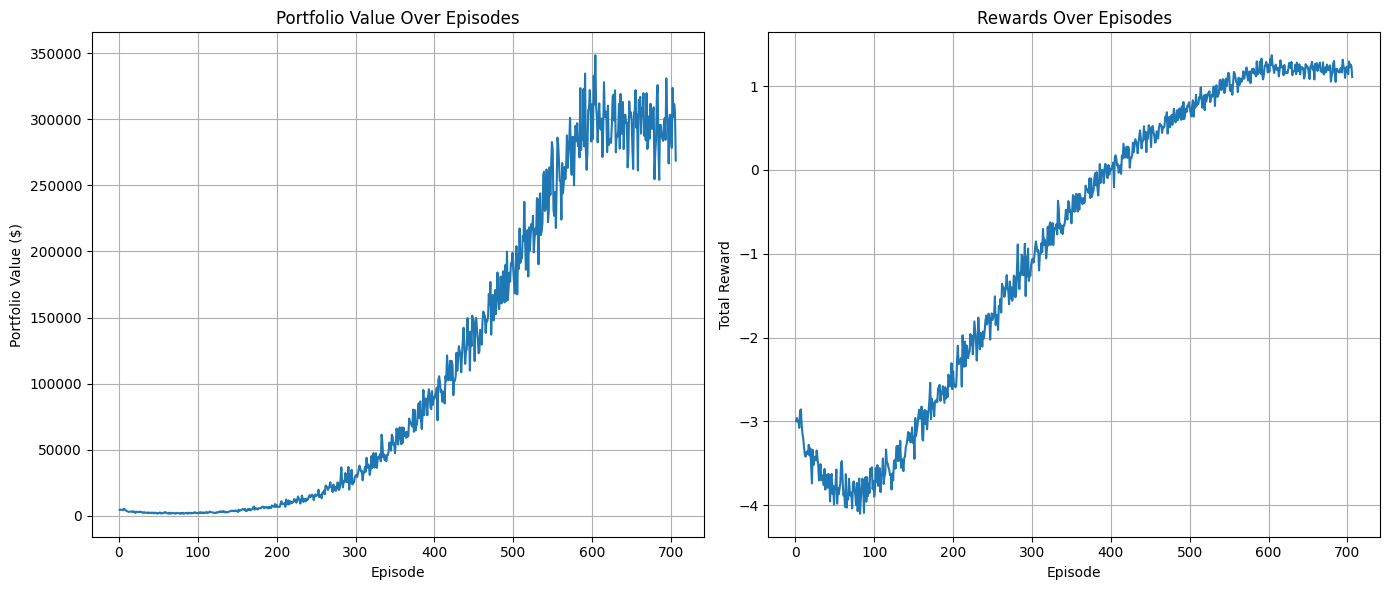

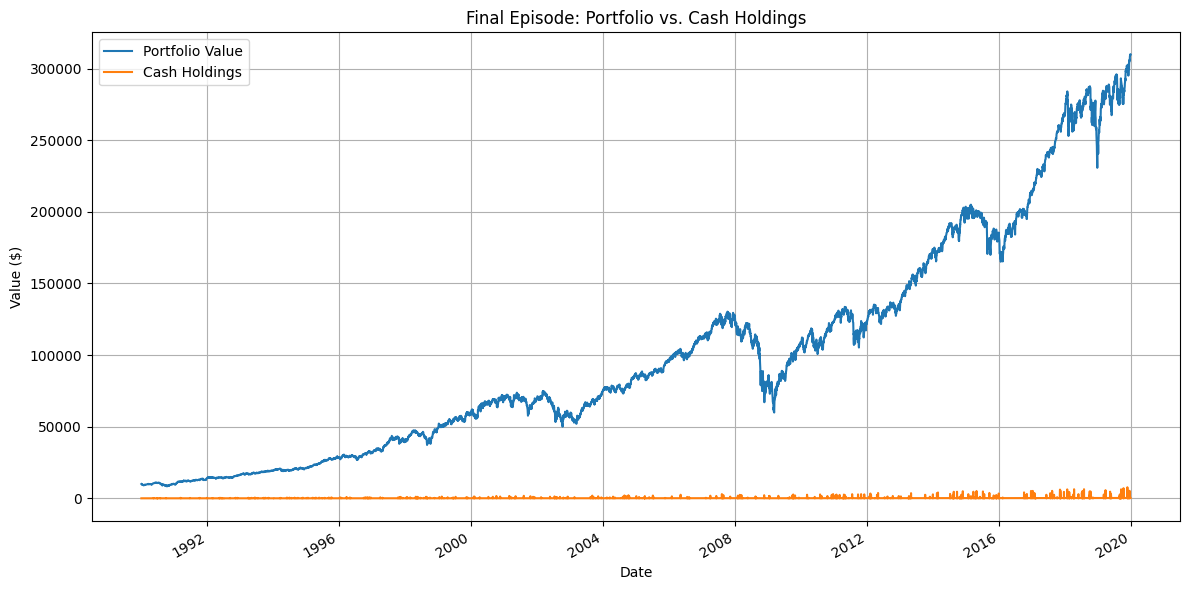

/scratch/4412781.1.l40s/ipykernel_1135821/2264158949.py:67: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


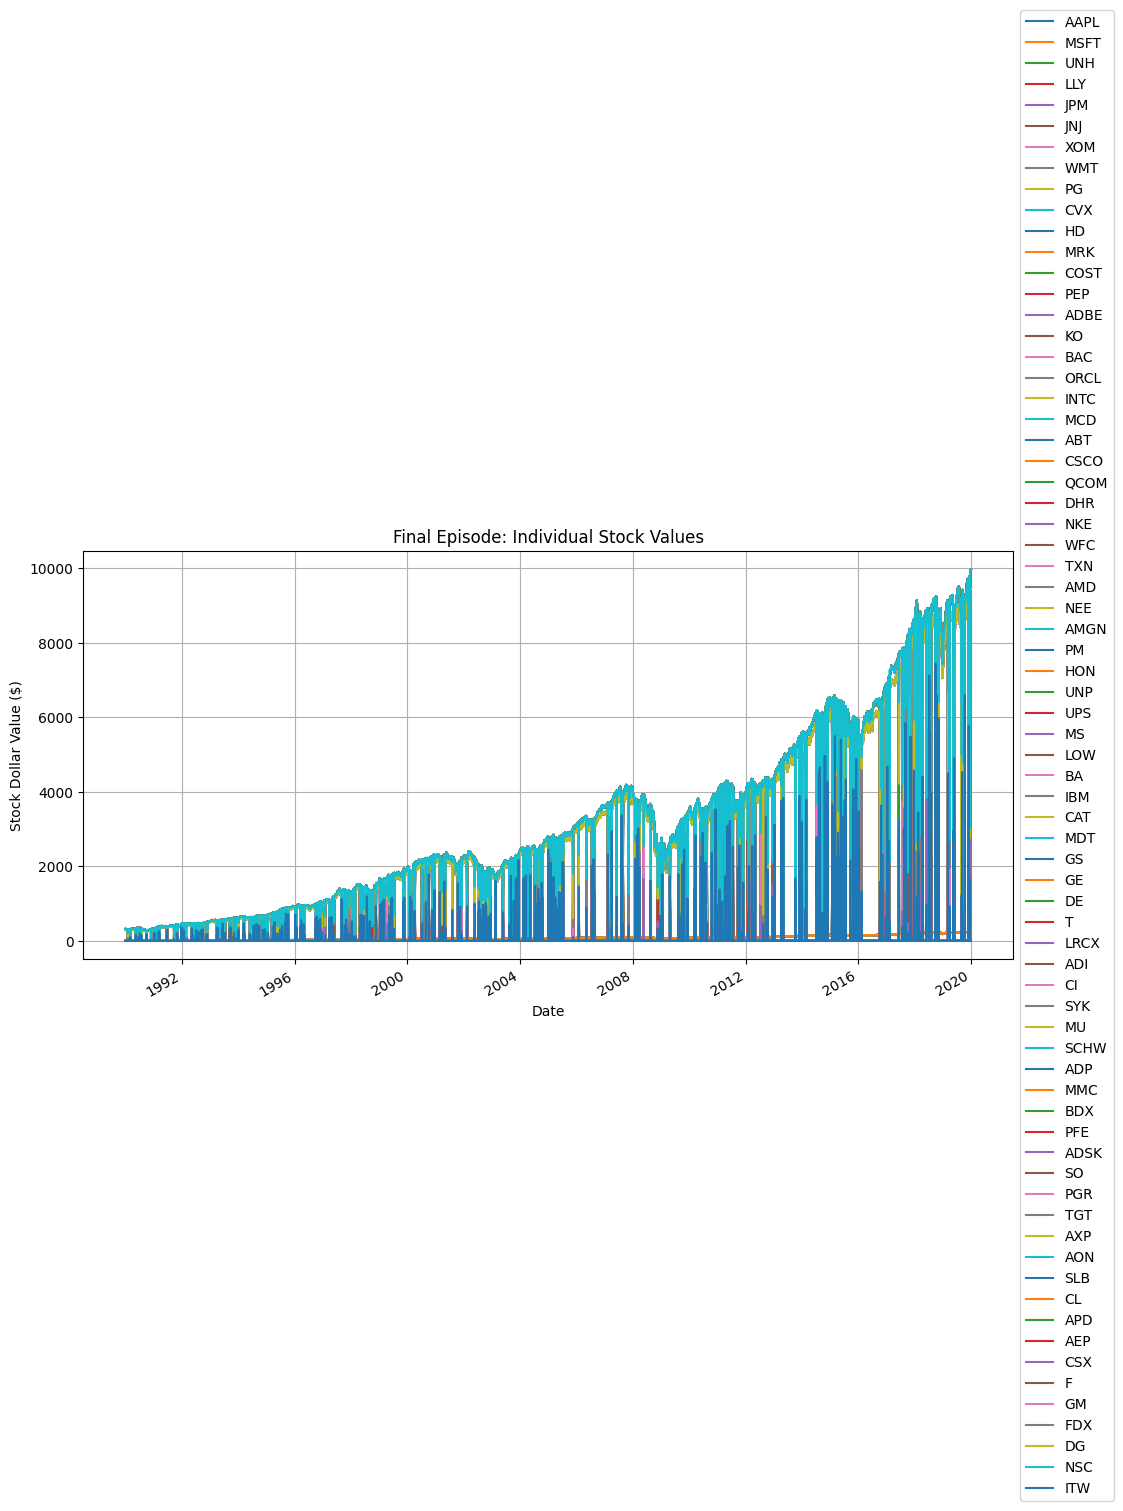

In [17]:
# --------------------------
# Plotting Section
# --------------------------
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1) Episode-level performance (Portfolio Value and Rewards over Episodes)
plt.figure(figsize=(14, 6))

# Portfolio Value over Episodes
plt.subplot(1, 2, 1)
plt.plot(range(1, len(portfolio_values) + 1), portfolio_values)
plt.xlabel("Episode")
plt.ylabel("Portfolio Value ($)")
plt.title("Portfolio Value Over Episodes")
plt.grid(True)

# Rewards over Episodes
plt.subplot(1, 2, 2)
plt.plot(range(1, len(episode_rewards) + 1), episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Rewards Over Episodes")
plt.grid(True)

plt.tight_layout()
plt.show()


# 2) Build a DataFrame for the final episode's daily values, indexed by real dates
dates = data.index[:len(daily_values)]
daily_df = pd.DataFrame({
    "Portfolio Value": daily_values,
    "Cash Holdings":   daily_cash
}, index=dates)

for i, ticker in enumerate(tickers):
    daily_df[ticker] = daily_stock_values[i]

# 3) Final Episode: Portfolio vs. Cash Holdings
fig, ax = plt.subplots(figsize=(12, 6))
daily_df[["Portfolio Value", "Cash Holdings"]].plot(ax=ax)
ax.set(
    xlabel="Date",
    ylabel="Value ($)",
    title="Final Episode: Portfolio vs. Cash Holdings"
)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.grid(True)
plt.tight_layout()
plt.show()


# 4) Final Episode: Individual Stock Dollar Values
fig, ax = plt.subplots(figsize=(12, 6))
daily_df[tickers].plot(ax=ax)
ax.set(
    xlabel="Date",
    ylabel="Stock Dollar Value ($)",
    title="Final Episode: Individual Stock Values"
)
ax.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.grid(True)
plt.tight_layout()
plt.show()


## Performance compared to SNP 500

In [19]:
# stock_prices came from a DataFrame `data` whose index is real dates
dates = []
daily_values = []
daily_cash   = []
daily_stock  = []

state = env.reset()
done = False
while not done:
    dates.append(data.index[env.current_step])
    # make your action, step:
    action = agent.select_action(state)
    next_state, reward, done, _ = env.step(action)
    # record
    prices = env.stock_prices[env.current_step-1]
    total_val = env.cash + (env.holdings * prices).sum()
    daily_values.append(total_val)
    daily_cash.append(env.cash)
    daily_stock.append((env.holdings * prices).tolist())
    state = next_state


In [20]:
spy = (
    yf.download("SPY",
                start=dates[0],
                end=dates[-1],
                auto_adjust=False)["Close"]
    .reindex(dates)     # align to your exact days
    .ffill().bfill()
)


[*********************100%***********************]  1 of 1 completed


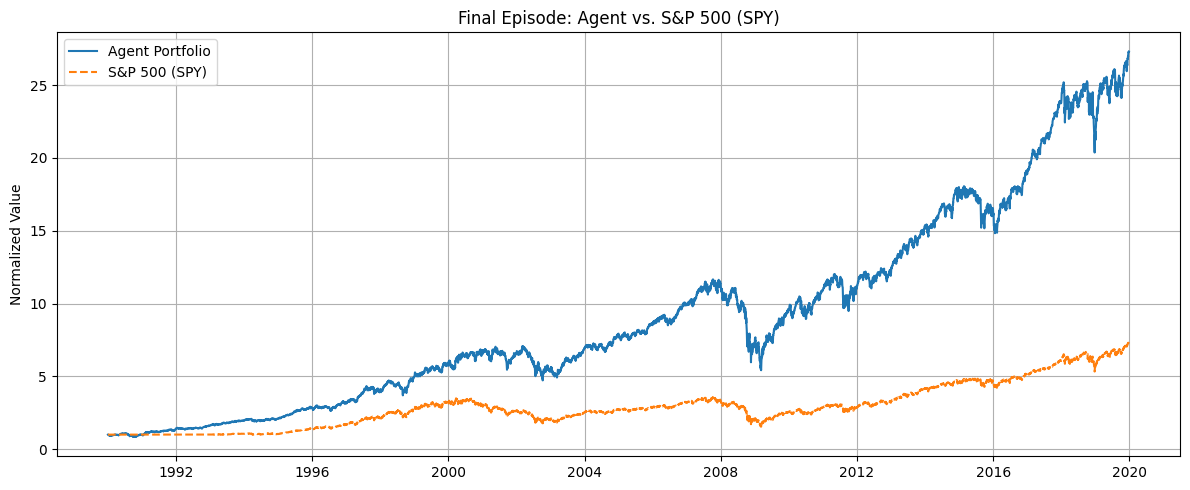

In [21]:
# normalize
norm_port = np.array(daily_values) / daily_values[0]
norm_spy  = spy.values       / spy.values[0]

# plot
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(dates, norm_port, label="Agent Portfolio")
ax.plot(dates, norm_spy,  "--", label="S&P 500 (SPY)")
ax.set_title("Final Episode: Agent vs. S&P 500 (SPY)")
ax.set_ylabel("Normalized Value")
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


# Eval

In [22]:
def evaluate_agent(agent, tickers, start_date='2020-01-01', end_date=None,
                   initial_cash=10000, transaction_cost=0.001, device=None):
    """
    Runs a single evaluation of a trained BCQ agent over the specified period.

    Args:
        agent: Trained BCQAgent instance (with networks loaded).
        tickers: List of stock tickers used in training.
        start_date: String 'YYYY-MM-DD', start of evaluation.
        end_date: String 'YYYY-MM-DD', end of evaluation. Defaults to latest.
        initial_cash: Starting cash balance.
        transaction_cost: Proportional transaction cost per trade.
        device: torch.device for inference.

    Returns:
        dates: List of evaluation dates.
        portf_values: List of daily portfolio values.
        bench_values: List of daily S&P 500 values.
    """
    # Fetch price data
    data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)["Close"]
    data = data.ffill().bfill()
    prices = data.values.astype(np.float32)
    dates = data.index

    # Fetch S&P500
    snp = yf.download('^GSPC', start=start_date, end=end_date, auto_adjust=False)["Close"].ffill().bfill().values

    # Build environment
    class EvalEnv(gym.Env):  # simple wrapper, similar to TradingEnv
        def __init__(self, prices, snp, initial_cash, transaction_cost):
            super().__init__()
            self.prices = prices
            self.snp = snp
            self.initial_cash = initial_cash
            self.num_stocks = prices.shape[1]
            self.transaction_cost = transaction_cost
            self.action_space = gym.spaces.Box(0, 1, (self.num_stocks+1,), np.float32)
            obs_low = np.zeros(self.num_stocks*2+1, np.float32)
            obs_high = np.full(self.num_stocks*2+1, np.inf, np.float32)
            self.observation_space = gym.spaces.Box(obs_low, obs_high, dtype=np.float32)

        def reset(self):
            self.step_idx = 0
            self.cash = float(self.initial_cash)
            self.holdings = np.zeros(self.num_stocks, np.float32)
            return self._obs()

        def _obs(self):
            return np.concatenate([self.prices[self.step_idx], self.holdings, [self.cash]])

        def step(self, action):
            # normalize
            action = np.clip(action, 1e-6, None)
            action /= action.sum()
            prices = self.prices[self.step_idx]
            total_val = (self.holdings * prices).sum() + self.cash
            target_vals = action[:-1] * total_val
            target_cash = action[-1] * total_val
            new_h = target_vals / prices
            trades = np.abs(new_h - self.holdings) * prices
            cost = self.transaction_cost * trades.sum()
            # advance
            next_prices = self.prices[self.step_idx+1]
            next_stock_val = (new_h * next_prices).sum()
            next_total = next_stock_val + target_cash - cost
            # compute reward relative to S&P
            ret_port = next_total/total_val - 1
            ret_bench = (self.snp[self.step_idx+1]/self.snp[self.step_idx]) - 1
            reward = ret_port - ret_bench
            # commit
            self.holdings = new_h
            self.cash = target_cash - cost
            self.step_idx += 1
            done = (self.step_idx >= len(self.prices)-1)
            return self._obs(), reward, done, {}

    # Initialize env and run
    env = EvalEnv(prices, snp, initial_cash, transaction_cost)
    state = env.reset()
    portf_vals = []
    bench_vals = []
    done = False

    # Set agent to greedy
    agent.epsilon = agent.epsilon_min

    while not done:
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        # record
        date = dates[env.step_idx]
        value = env.cash + (env.holdings * env.prices[env.step_idx]).sum()
        portf_vals.append(value)
        bench_vals.append(env.snp[env.step_idx])
        state = next_state

    # Metrics
    cum_return = (portf_vals[-1]/initial_cash - 1)*100
    bench_return = (bench_vals[-1]/bench_vals[0] - 1)*100
    print(f"Evaluation from {dates[0].date()} to {dates[-1].date()}")
    print(f"Portfolio Cumulative Return: {cum_return:.2f}%")
    print(f"Benchmark (S&P 500) Return: {bench_return:.2f}%\n")

    # Plotting
    plt.figure()
    plt.plot(dates[1:], portf_vals, label='Portfolio')
    plt.plot(dates[1:], bench_vals, label='S&P 500')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Portfolio vs S&P 500')
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure()
    plt.plot(dates[1:], np.diff(portf_vals)/portf_vals[:-1], label='Daily Portf Ret')
    plt.plot(dates[1:], np.diff(bench_vals)/bench_vals[:-1], label='Daily Bench Ret')
    plt.xlabel('Date')
    plt.ylabel('Daily Return')
    plt.title('Daily Returns Comparison')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return dates[1:], portf_vals, bench_vals

[*********************100%***********************]  71 of 71 completed
[*********************100%***********************]  1 of 1 completed


Evaluation from 2021-01-04 to 2025-04-11
Portfolio Cumulative Return: 58.86%


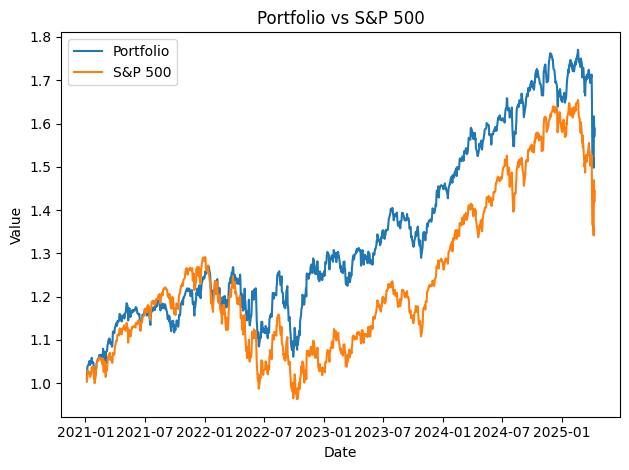

In [23]:
import gym
import numpy as np
import torch
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd


def evaluate_agent(agent, tickers, start_date='2020-01-01', end_date=None,
                   initial_cash=10000, transaction_cost=0.001, device=None):
    """
    Runs a single evaluation of a trained BCQ agent over the specified period.

    Args:
        agent: Trained BCQAgent instance (should already be in memory).
        tickers: List of stock tickers used in training.
        start_date: String 'YYYY-MM-DD', start of evaluation.
        end_date: String 'YYYY-MM-DD', end of evaluation. Defaults to latest.
        initial_cash: Starting cash balance.
        transaction_cost: Proportional transaction cost per trade.
        device: torch.device for inference.

    Returns:
        dates: List of evaluation dates.
        portf_values: List of daily portfolio values.
        bench_values: List of daily S&P 500 values.
    """
    # Fetch price data
    data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)["Close"]
    data = data.ffill().bfill()
    prices = data.values.astype(np.float32)
    dates = data.index

    # Fetch S&P500
    snp = yf.download('^GSPC', start=start_date, end=end_date, auto_adjust=False)["Close"].ffill().bfill().values

    # Evaluation environment (mirror of TradingEnv)
    class EvalEnv(gym.Env):
        def __init__(self, prices, snp, initial_cash, transaction_cost):
            super().__init__()
            self.prices = prices
            self.snp = snp
            self.initial_cash = initial_cash
            self.num_stocks = prices.shape[1]
            self.transaction_cost = transaction_cost
            self.action_space = gym.spaces.Box(0, 1, (self.num_stocks+1,), np.float32)
            obs_low = np.zeros(self.num_stocks*2+1, np.float32)
            obs_high = np.full(self.num_stocks*2+1, np.inf, np.float32)
            self.observation_space = gym.spaces.Box(obs_low, obs_high, dtype=np.float32)

        def reset(self):
            self.step_idx = 0
            self.cash = float(self.initial_cash)
            self.holdings = np.zeros(self.num_stocks, np.float32)
            return self._obs()

        def _obs(self):
            return np.concatenate([self.prices[self.step_idx], self.holdings, [self.cash]])

        def step(self, action):
            # normalize action
            action = np.clip(action, 1e-6, None)
            action /= action.sum()

            # compute current total value
            prices = self.prices[self.step_idx]
            total_val = (self.holdings * prices).sum() + self.cash

            # determine new holdings and cost
            target_vals = action[:-1] * total_val
            target_cash = action[-1] * total_val
            new_h = target_vals / prices
            trades = np.abs(new_h - self.holdings) * prices
            cost = self.transaction_cost * trades.sum()

            # advance to next step
            next_prices = self.prices[self.step_idx + 1]
            next_stock_val = (new_h * next_prices).sum()
            next_total = next_stock_val + target_cash - cost

            # reward relative to S&P 500
            ret_port = next_total / total_val - 1
            ret_bench = (self.snp[self.step_idx + 1] / self.snp[self.step_idx]) - 1
            reward = ret_port - ret_bench

            # commit
            self.holdings = new_h
            self.cash = target_cash - cost
            self.step_idx += 1
            done = (self.step_idx >= len(self.prices) - 1)
            return self._obs(), reward, done, {}

    # Run evaluation
    env = EvalEnv(prices, snp, initial_cash, transaction_cost)
    state = env.reset()
    portf_vals, bench_vals = [], []

    # force greedy policy
    agent.epsilon = agent.epsilon_min

    while True:
        action = agent.select_action(state)
        state, _, done, _ = env.step(action)
        value = env.cash + (env.holdings * env.prices[env.step_idx]).sum()
        portf_vals.append(value)
        bench_vals.append(env.snp[env.step_idx])
        if done:
            break

    # Performance metrics
    cum_return = (portf_vals[-1] / initial_cash - 1) * 100
    bench_return = (bench_vals[-1] / bench_vals[0] - 1) * 100
    print(f"Evaluation from {dates[0].date()} to {dates[-1].date()}")
    print(f"Portfolio Cumulative Return: {cum_return:.2f}%")
    norm_portf = np.array(portf_vals) / 10000
    norm_bench = np.array(bench_vals) / 3714
    # Plot portfolio vs benchmark
    plt.figure()
    plt.plot(dates[1:],norm_portf,  label='Portfolio')
    plt.plot(dates[1:],norm_bench , label='S&P 500')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Portfolio vs S&P 500')
    plt.legend()
    plt.tight_layout(); plt.show()



swag = evaluate_agent(
    agent,
    tickers,
    start_date='2021-01-01',
    end_date='2025-04-14',
    initial_cash=10000,
    transaction_cost=0.00001,
    device=device  # if your agent uses device for inference
     )
